# Projek Ujian Tengah Semester (UTS) Mata Kuliah Penambangan Data

## Feature Selection

<b>KELOMPOK 16 :   </b>      
Muhammad Yusuf — 122140193  
Cornelius Linux_122140079   
Chandra Budi Wijaya_122140093

1. Kasus:  
Dataset memiliki 12 kolom, namun beberapa fitur seperti Supplier atau Cabang mungkin tidak
relevan untuk model prediksi stok.

2. Tugas:  
Gunakan teknik correlation analysis atau feature importance (Random Forest / Chi-square),
Mutual Information (MI), Wrapper Methods, Embedded Methods untuk memilih fitur
penting.

3. Pertanyaan Studi Kasus:  
Bagaimana kamu menentukan fitur mana yang relevan untuk model prediksi stok obat harian?

## Penjelasan Metode

**Random Forest** adalah algoritma ensemble berbasis pohon keputusan yang digunakan untuk klasifikasi dan regresi. Metode ini membangun banyak pohon keputusan secara acak dan menggabungkan hasilnya untuk meningkatkan akurasi prediksi serta mengurangi risiko overfitting. Random Forest juga menyediakan skor *feature importance* yang menunjukkan seberapa besar kontribusi setiap fitur terhadap prediksi model [1].

**Feature Selection** adalah proses memilih subset fitur yang paling relevan dari seluruh fitur yang tersedia dalam dataset. Tujuannya adalah meningkatkan performa model, mengurangi kompleksitas, dan mencegah overfitting. Teknik feature selection dapat dilakukan dengan metode statistik, machine learning, atau kombinasi keduanya, seperti menggunakan skor korelasi, Random Forest, atau Mutual Information [2].

**Mutual Information (MI)** adalah ukuran statistik yang mengukur seberapa besar informasi yang diperoleh tentang satu variabel dari variabel lain. Dalam konteks feature selection, MI digunakan untuk menilai hubungan non-linear antara fitur dan target, sehingga fitur yang memiliki MI tinggi dianggap lebih relevan untuk prediksi [3].

**Correlation Analysis (Pearson)** adalah metode statistik untuk mengukur kekuatan dan arah hubungan linear antara dua variabel kontinu. Koefisien korelasi Pearson berkisar antara -1 hingga +1, di mana nilai mendekati +1 atau -1 menunjukkan korelasi kuat, sedangkan nilai mendekati 0 menunjukkan tidak ada korelasi linear. Dalam feature selection, fitur dengan korelasi tinggi terhadap target variable dianggap lebih penting [4].

**Recursive Feature Elimination (RFE)** adalah metode wrapper yang secara iteratif membangun model dan menghilangkan fitur dengan bobot atau koefisien terendah hingga mencapai jumlah fitur yang diinginkan. RFE bekerja dengan melatih model, menghitung ranking fitur berdasarkan importance, menghilangkan fitur dengan ranking terendah, dan mengulangi proses hingga jumlah fitur optimal tercapai [5].

**Lasso Regression (L1 Regularization)** adalah metode embedded yang menambahkan penalty berupa jumlah nilai absolut koefisien ke dalam fungsi loss. Karakteristik utama Lasso adalah kemampuannya untuk mengecilkan koefisien fitur yang tidak penting menjadi tepat nol, sehingga secara otomatis melakukan feature selection. Parameter alpha mengontrol kekuatan regularisasi, di mana alpha yang lebih besar menghasilkan lebih banyak koefisien yang menjadi nol [6].

**Ridge Regression (L2 Regularization)** adalah metode embedded yang menambahkan penalty berupa kuadrat nilai koefisien ke dalam fungsi loss. Berbeda dengan Lasso, Ridge tidak mengecilkan koefisien menjadi tepat nol, melainkan hanya menyusutkan (shrink) nilai koefisien mendekati nol. Ridge berguna untuk menangani multicollinearity dan memberikan stabilitas model ketika terdapat fitur yang berkorelasi tinggi [7].

---

In [2]:
# ==============================================
# FEATURE SELECTION - RAW FEATURES (TANPA FEATURE ENGINEERING)
# Kelompok 16: Muhammad Yusuf, Cornelius Linux, Chandra Budi Wijaya
# ==============================================
# Tujuan: Membandingkan hasil feature selection dengan menggunakan fitur MENTAH
# tanpa agregasi, untuk menunjukkan pentingnya feature engineering

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV


In [3]:
# ==============================================
# 1. PARSING DATA PEMBELIAN
# ==============================================
print("\n" + "="*70)
print("1. PARSING DATA PEMBELIAN")
print("="*70)

data = []
kode, nama, unit = None, None, None
with open('dataset-apotek-pembelian.tsv', 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        line = line.strip()
        if not line or set(line) == {'-'}:
            continue

        # Baris kode produk
        if re.match(r'^[A-Z0-9]{5,}\s+', line):
            parts = re.split(r'\s{2,}', line)
            kode = parts[0].strip()
            nama = parts[1].strip() if len(parts) > 1 else None
            unit = parts[-1].strip() if len(parts) > 2 else None
            continue

        # Baris transaksi
        if re.match(r'^\d{2}-\d{2}-\d{2}', line):
            tanggal = line[0:8].strip()
            no_transaksi = line[9:35].strip()
            qty_masuk = line[36:47].strip()
            nilai_masuk = line[48:61].strip()
            qty_keluar = line[62:73].strip()
            nilai_keluar = line[74:].strip()
            data.append([kode, nama, unit, tanggal, no_transaksi, qty_masuk, nilai_masuk, qty_keluar, nilai_keluar])

df = pd.DataFrame(data, columns=[
    'Kode', 'Nama_Produk', 'Unit', 'Tanggal', 'No_Transaksi',
    'Qty_Masuk', 'Nilai_Masuk', 'Qty_Keluar', 'Nilai_Keluar'
])

# Cleaning & Conversion
def to_float(val):
    val = str(val).replace('.', '').replace(',', '.')
    try:
        return float(val)
    except:
        return 0.0

for c in ['Qty_Masuk', 'Nilai_Masuk', 'Qty_Keluar', 'Nilai_Keluar']:
    df[c] = df[c].apply(to_float)

df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%y', errors='coerce')
df = df.dropna(subset=['Tanggal'])

# Tambahkan fitur temporal SEDERHANA (bukan agregasi)
df['Bulan'] = df['Tanggal'].dt.month
df['Tahun'] = df['Tanggal'].dt.year
df['Hari'] = df['Tanggal'].dt.day
df['Hari_dalam_Minggu'] = df['Tanggal'].dt.dayofweek  # 0=Senin, 6=Minggu

print(f"✓ Data mentah pembelian: {len(df)} transaksi")
print(f"\nSample data pembelian (raw):")
print(df[['Kode', 'Tanggal', 'Qty_Masuk', 'Qty_Keluar', 'Nilai_Masuk', 'Nilai_Keluar', 'Bulan', 'Tahun']].head(10))



1. PARSING DATA PEMBELIAN
✓ Data mentah pembelian: 138364 transaksi

Sample data pembelian (raw):
      Kode    Tanggal  Qty_Masuk  Qty_Keluar  Nilai_Masuk  Nilai_Keluar  \
0  A000001 2021-07-06       10.0         0.0       2520.0           0.0   
1  A000001 2021-07-12        0.0         1.0          0.0        3000.0   
2  A000001 2021-07-12        0.0         1.0          0.0        3000.0   
3  A000001 2021-07-12        0.0         1.0          0.0        3000.0   
4  A000001 2021-07-12        0.0         1.0          0.0        3000.0   
5  A000001 2021-07-12        0.0         1.0          0.0        3000.0   
6  A000001 2021-07-12        0.0         1.0          0.0        3000.0   
7  A000001 2021-07-12        0.0         2.0          0.0        3000.0   
8  A000001 2021-07-13        0.0         1.0          0.0        3000.0   
9  A000001 2021-07-13        0.0         1.0          0.0        4000.0   

   Bulan  Tahun  
0      7   2021  
1      7   2021  
2      7   2021  
3  

In [4]:
# ==============================================
# 2. PARSING DATA STOK
# ==============================================
print("\n" + "="*70)
print("2. PARSING DATA STOK")
print("="*70)

# Baca file stok
df_stok = pd.read_fwf('dataset-apotek-stok.tsv', encoding='utf-8')

# Hapus kolom kosong
df_stok = df_stok.dropna(axis=1, how='all')
df_stok = df_stok.loc[:, ~df_stok.columns.str.contains('Unnamed', case=False)]

# Normalisasi nama kolom
df_stok.columns = (
    df_stok.columns.str.strip()
    .str.upper()
    .str.replace('.', '', regex=False)
    .str.replace(' ', '_', regex=False)
)

print(f"Kolom data stok: {df_stok.columns.tolist()}")

# Deteksi kolom stok
stok_col = [col for col in df_stok.columns if 'QTY' in col and 'STOK' in col]
if not stok_col:
    raise KeyError(f"Kolom stok tidak ditemukan! Kolom: {df_stok.columns.tolist()}")
stok_col = stok_col[0]

# Bersihkan kolom stok
df_stok = df_stok[~df_stok[stok_col].astype(str).str.contains('-', regex=False, na=False)]
df_stok = df_stok[df_stok[stok_col].astype(str).str.strip() != '']

df_stok[stok_col] = (
    df_stok[stok_col]
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# Rename untuk merge
df_stok = df_stok.rename(columns={
    'KODE': 'Kode',
    'NAMA_PRODUK': 'Nama_Produk',
    'LOKASI': 'Lokasi',
    stok_col: 'Stok_Aktual',
    'UNIT': 'Unit'
})

print(f"✓ Data stok dimuat: {len(df_stok)} produk")
print(df_stok.head())


2. PARSING DATA STOK
Kolom data stok: ['KODE', 'NAMA_PRODUK', 'LOKASI', 'QTYSTOK', 'UNIT']
✓ Data stok dimuat: 1518 produk
      Kode         Nama_Produk Lokasi  Stok_Aktual   Unit
0  A000001          ANATON TAB   ETL1         12.0  STRIP
1   A00001       ACTIVED HIJAU  ETL3A          2.0    BTL
2  A000012  APIALYS SYR 100 ML  ETL3A          2.0    BTL
3  A000014     ALKOHOL 1000 ML  ETL3B          7.0    BTL
4  A000016     ALLOPURINOL 300   RAK2         40.0  STRIP


In [5]:
# ==============================================
# 3. AGREGASI MINIMAL (HANYA UNTUK MERGE)
# ==============================================
print("\n" + "="*70)
print("3. AGREGASI MINIMAL PER PRODUK (untuk merge dengan stok)")
print("="*70)

# Kita tetap perlu agregasi per produk karena target (Stok_Aktual) adalah per produk
# TAPI: kita TIDAK membuat fitur agregat (sum, mean, std), hanya mengambil NILAI TERAKHIR
pembelian_simple = df.sort_values(['Kode', 'Tanggal']).groupby('Kode').tail(1).reset_index(drop=True)

print(f"✓ Mengambil transaksi TERAKHIR per produk: {len(pembelian_simple)} produk")
print(f"\nSample data (last transaction per product):")
print(pembelian_simple[['Kode', 'Tanggal', 'Qty_Masuk', 'Qty_Keluar', 'Bulan', 'Tahun']].head(10))


3. AGREGASI MINIMAL PER PRODUK (untuk merge dengan stok)
✓ Mengambil transaksi TERAKHIR per produk: 2024 produk

Sample data (last transaction per product):
        Kode    Tanggal  Qty_Masuk  Qty_Keluar  Bulan  Tahun
0    A000001 2021-12-21        0.0         1.0     12   2021
1  A00000156 2021-04-10        0.0         1.0      4   2021
2  A00000157 2021-07-25        0.0         1.0      7   2021
3    A000002 2021-07-19        0.0         2.0      7   2021
4     A00001 2021-12-27        1.0         0.0     12   2021
5    A000011 2021-07-09        0.0         1.0      7   2021
6    A000012 2021-12-22        1.0         0.0     12   2021
7    A000014 2021-12-28        0.0         1.0     12   2021
8    A000016 2021-12-30        0.0         1.0     12   2021
9    A000018 2021-11-30        0.0         1.0     11   2021


In [6]:
# ==============================================
# 4. MERGE DATA PEMBELIAN + STOK
# ==============================================
print("\n" + "="*70)
print("4. MERGE DATA PEMBELIAN (RAW) + STOK")
print("="*70)

# Merge berdasarkan Kode produk
data_gabungan = pembelian_simple.merge(
    df_stok[['Kode', 'Stok_Aktual', 'Lokasi']], 
    on='Kode', 
    how='inner'
)

print(f"✓ Data gabungan: {len(data_gabungan)} produk")

# Label encoding untuk Lokasi
le_lokasi = LabelEncoder()
data_gabungan['Lokasi_Encoded'] = le_lokasi.fit_transform(data_gabungan['Lokasi'].astype(str))

print(f"\n✓ Data siap untuk analisis!")
print(f"Target: Stok_Aktual")

# Tampilkan fitur yang akan digunakan
print(f"\nKolom yang tersedia:")
for i, col in enumerate(data_gabungan.columns, 1):
    print(f"  {i}. {col}")


4. MERGE DATA PEMBELIAN (RAW) + STOK
✓ Data gabungan: 359 produk

✓ Data siap untuk analisis!
Target: Stok_Aktual

Kolom yang tersedia:
  1. Kode
  2. Nama_Produk
  3. Unit
  4. Tanggal
  5. No_Transaksi
  6. Qty_Masuk
  7. Nilai_Masuk
  8. Qty_Keluar
  9. Nilai_Keluar
  10. Bulan
  11. Tahun
  12. Hari
  13. Hari_dalam_Minggu
  14. Stok_Aktual
  15. Lokasi
  16. Lokasi_Encoded


In [7]:
# ==============================================
# 5. PREPARE FEATURES (RAW)
# ==============================================
print("\n" + "="*70)
print("5. PERSIAPAN FITUR (RAW - TANPA AGREGASI)")
print("="*70)

# Exclude kolom non-numerik dan target
exclude_cols = ['Kode', 'Nama_Produk', 'Unit', 'Tanggal', 'No_Transaksi', 'Lokasi', 'Stok_Aktual']
fitur_model = [col for col in data_gabungan.columns if col not in exclude_cols]

print(f"\n🔍 FITUR RAW YANG DIGUNAKAN ({len(fitur_model)} fitur):")
for i, f in enumerate(fitur_model, 1):
    print(f"  {i}. {f}")

print("""
⚠️ CATATAN: 
   - Ini adalah fitur MENTAH dari transaksi TERAKHIR setiap produk
   - TIDAK ada agregasi (sum, mean, std, max)
   - Hanya nilai single transaction
   - Tujuan: Membandingkan dengan feature engineering approach
""")

# Siapkan data
X = data_gabungan[fitur_model].copy()
y = data_gabungan['Stok_Aktual'].copy()

# Hapus missing values
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print(f"\n✓ Data setelah cleaning: {len(X)} produk")
print(f"✓ Jumlah fitur: {X.shape[1]}")


5. PERSIAPAN FITUR (RAW - TANPA AGREGASI)

🔍 FITUR RAW YANG DIGUNAKAN (9 fitur):
  1. Qty_Masuk
  2. Nilai_Masuk
  3. Qty_Keluar
  4. Nilai_Keluar
  5. Bulan
  6. Tahun
  7. Hari
  8. Hari_dalam_Minggu
  9. Lokasi_Encoded

⚠️ CATATAN: 
   - Ini adalah fitur MENTAH dari transaksi TERAKHIR setiap produk
   - TIDAK ada agregasi (sum, mean, std, max)
   - Hanya nilai single transaction
   - Tujuan: Membandingkan dengan feature engineering approach


✓ Data setelah cleaning: 359 produk
✓ Jumlah fitur: 9



6. CORRELATION ANALYSIS (PEARSON) - RAW FEATURES

📊 Korelasi terhadap Stok_Aktual:
Qty_Keluar           0.219364
Hari_dalam_Minggu    0.081544
Qty_Masuk            0.078935
Bulan                0.065340
Lokasi_Encoded       0.057054
Hari                 0.030195
Nilai_Masuk         -0.102567
Nilai_Keluar        -0.113685
Tahun                     NaN
Name: Stok_Aktual, dtype: float64


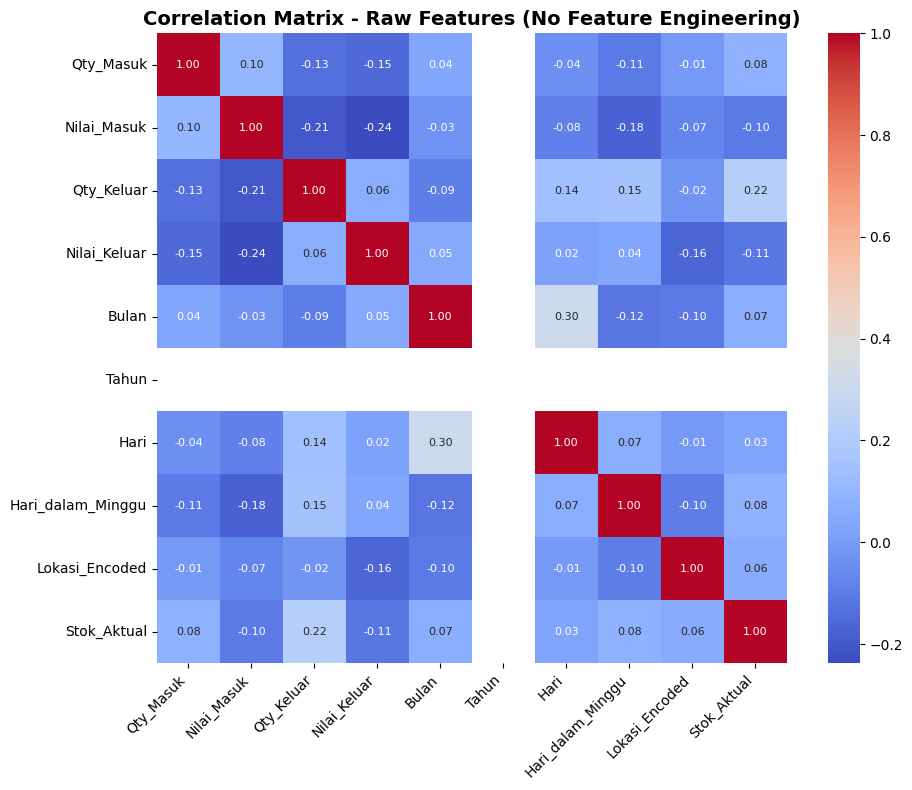

In [8]:
# ==============================================
# 6. CORRELATION ANALYSIS
# ==============================================
print("\n" + "="*70)
print("6. CORRELATION ANALYSIS (PEARSON) - RAW FEATURES")
print("="*70)

# Correlation matrix
corr = X.join(y).corr()
stok_corr = corr['Stok_Aktual'].sort_values(ascending=False)

print("\n📊 Korelasi terhadap Stok_Aktual:")
print(stok_corr.drop('Stok_Aktual'))

# Visualisasi
plt.figure(figsize=(10, 8))
sns.heatmap(
    X.join(y).corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    square=True
)
plt.title("Correlation Matrix - Raw Features (No Feature Engineering)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_raw_features.png', dpi=300, bbox_inches='tight')
plt.show()


7. RANDOM FOREST FEATURE IMPORTANCE - RAW FEATURES

📊 Random Forest Feature Importance:
          Feature  Importance
     Nilai_Keluar    0.368659
   Lokasi_Encoded    0.228827
       Qty_Keluar    0.140522
             Hari    0.130995
Hari_dalam_Minggu    0.065697
            Bulan    0.037118
        Qty_Masuk    0.019486
      Nilai_Masuk    0.008697
            Tahun    0.000000


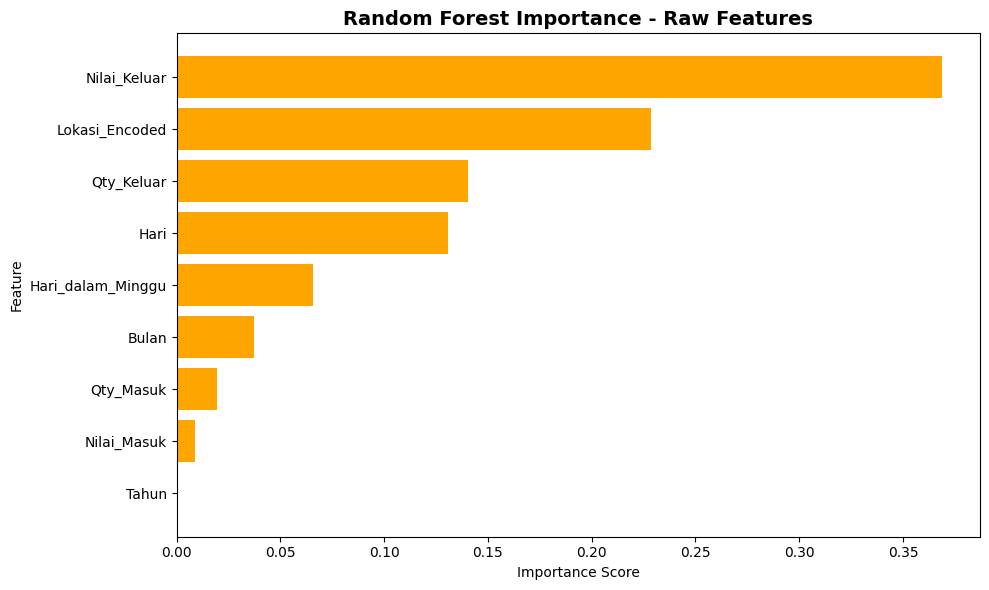

In [9]:
# ==============================================
# 7. RANDOM FOREST FEATURE IMPORTANCE
# ==============================================
print("\n" + "="*70)
print("7. RANDOM FOREST FEATURE IMPORTANCE - RAW FEATURES")
print("="*70)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n📊 Random Forest Feature Importance:")
print(rf_importance.to_string(index=False))

# Visualisasi
plt.figure(figsize=(10, 6))
plt.barh(rf_importance['Feature'], rf_importance['Importance'], color='orange')
plt.gca().invert_yaxis()
plt.title('Random Forest Importance - Raw Features', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('rf_importance_raw_features.png', dpi=300, bbox_inches='tight')
plt.show()



8. MUTUAL INFORMATION - RAW FEATURES

📊 Mutual Information Scores:
          Feature  MI_Score
     Nilai_Keluar  0.170843
        Qty_Masuk  0.148140
   Lokasi_Encoded  0.145541
      Nilai_Masuk  0.106438
            Tahun  0.054697
       Qty_Keluar  0.043272
            Bulan  0.033483
             Hari  0.025412
Hari_dalam_Minggu  0.019402


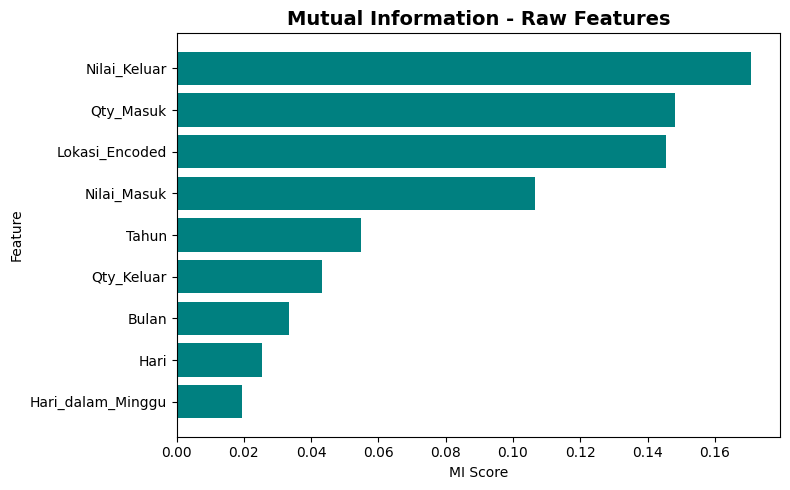

In [10]:
# ==============================================
# 8. MUTUAL INFORMATION
# ==============================================
print("\n" + "="*70)
print("8. MUTUAL INFORMATION - RAW FEATURES")
print("="*70)

mi = mutual_info_regression(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns, 
    'MI_Score': mi
}).sort_values(by='MI_Score', ascending=False)

print("\n📊 Mutual Information Scores:")
print(mi_df.to_string(index=False))

# Visualisasi
plt.figure(figsize=(8, 5))
plt.barh(mi_df['Feature'], mi_df['MI_Score'], color='teal')
plt.gca().invert_yaxis()
plt.title('Mutual Information - Raw Features', fontsize=14, fontweight='bold')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('mi_raw_features.png', dpi=300, bbox_inches='tight')
plt.show()



9. RECURSIVE FEATURE ELIMINATION (RFE) - RAW FEATURES

=== RFE Analysis ===

Top 3 fitur terpilih:
  1. Qty_Keluar
  2. Bulan
  3. Hari_dalam_Minggu

Top 5 fitur terpilih:
  1. Qty_Masuk
  2. Qty_Keluar
  3. Bulan
  4. Hari_dalam_Minggu
  5. Lokasi_Encoded

Top 7 fitur terpilih:
  1. Qty_Masuk
  2. Qty_Keluar
  3. Nilai_Keluar
  4. Bulan
  5. Hari
  6. Hari_dalam_Minggu
  7. Lokasi_Encoded



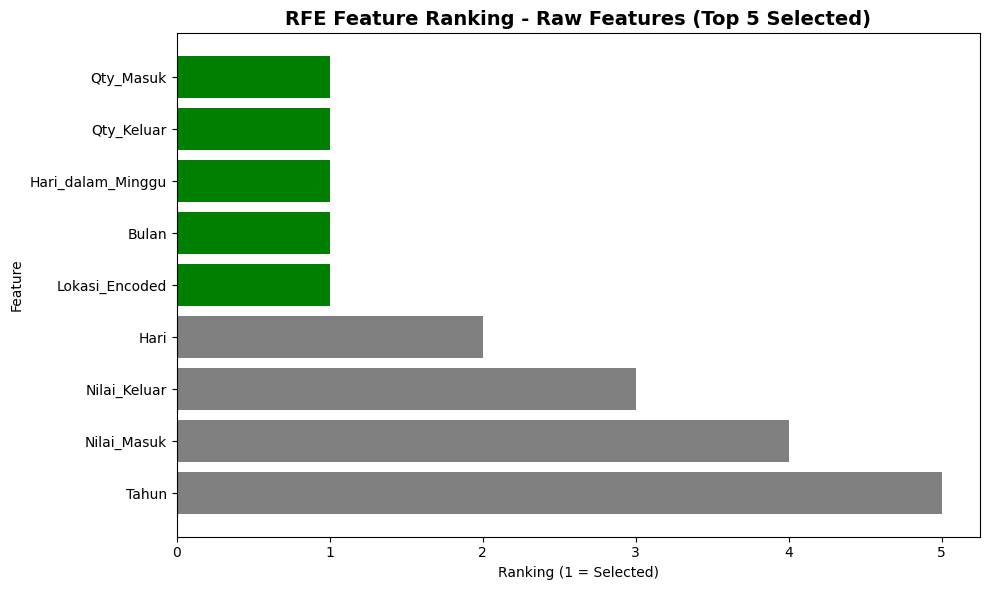


✓ Fitur terpilih RFE (Top 5): ['Qty_Masuk', 'Qty_Keluar', 'Bulan', 'Hari_dalam_Minggu', 'Lokasi_Encoded']


In [11]:
# ==============================================
# 9. RFE (RECURSIVE FEATURE ELIMINATION)
# ==============================================
print("\n" + "="*70)
print("9. RECURSIVE FEATURE ELIMINATION (RFE) - RAW FEATURES")
print("="*70)

print("\n=== RFE Analysis ===\n")

# Coba berbagai jumlah fitur
for n_features in [3, 5, 7]:
    estimator = LinearRegression()
    rfe = RFE(estimator=estimator, n_features_to_select=n_features)
    rfe.fit(X, y)
    
    selected_features = X.columns[rfe.support_].tolist()
    
    print(f"Top {n_features} fitur terpilih:")
    for i, feature in enumerate(selected_features, 1):
        print(f"  {i}. {feature}")
    print("")

# Visualisasi RFE
rfe_final = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe_final.fit(X, y)

rfe_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe_final.ranking_
}).sort_values('Ranking')

plt.figure(figsize=(10, 6))
colors_rfe = ['green' if rank == 1 else 'gray' for rank in rfe_ranking['Ranking']]
plt.barh(rfe_ranking['Feature'], rfe_ranking['Ranking'], color=colors_rfe)
plt.gca().invert_yaxis()
plt.title('RFE Feature Ranking - Raw Features (Top 5 Selected)', fontsize=14, fontweight='bold')
plt.xlabel('Ranking (1 = Selected)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('rfe_raw_features.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Fitur terpilih RFE (Top 5): {X.columns[rfe_final.support_].tolist()}")



10. LASSO REGRESSION (L1) - RAW FEATURES

📊 Alpha optimal (LassoCV): 10.3954

Koefisien Lasso:
          Feature   Coefficient  Abs_Coefficient
       Qty_Keluar  2.533411e-15     2.533411e-15
        Qty_Masuk  0.000000e+00     0.000000e+00
      Nilai_Masuk -0.000000e+00     0.000000e+00
     Nilai_Keluar -0.000000e+00     0.000000e+00
            Bulan  0.000000e+00     0.000000e+00
            Tahun  0.000000e+00     0.000000e+00
             Hari  0.000000e+00     0.000000e+00
Hari_dalam_Minggu  0.000000e+00     0.000000e+00
   Lokasi_Encoded  0.000000e+00     0.000000e+00

✓ Fitur terpilih (koefisien ≠ 0): ['Qty_Keluar']
✓ Jumlah fitur terpilih: 1 dari 9


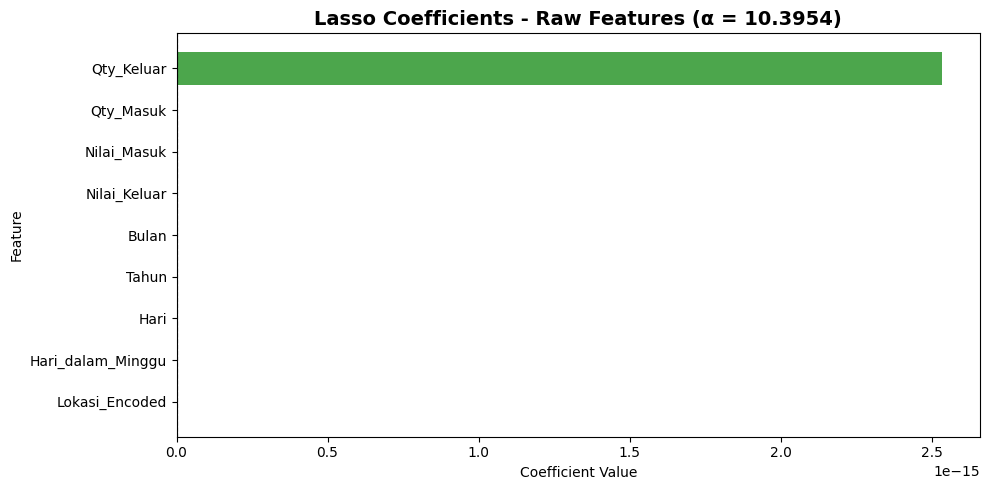

In [12]:
# ==============================================
# 10. LASSO REGRESSION
# ==============================================
print("\n" + "="*70)
print("10. LASSO REGRESSION (L1) - RAW FEATURES")
print("="*70)

# Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso CV
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_scaled, y)

print(f"\n📊 Alpha optimal (LassoCV): {lasso_cv.alpha_:.4f}\n")

lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000, random_state=42)
lasso.fit(X_scaled, y)

lasso_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_,
    'Abs_Coefficient': np.abs(lasso.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("Koefisien Lasso:")
print(lasso_coef.to_string(index=False))

selected_lasso = lasso_coef[lasso_coef['Coefficient'] != 0]['Feature'].tolist()
print(f"\n✓ Fitur terpilih (koefisien ≠ 0): {selected_lasso}")
print(f"✓ Jumlah fitur terpilih: {len(selected_lasso)} dari {len(X.columns)}")

# Visualisasi
plt.figure(figsize=(10, 5))
colors_lasso = ['green' if c != 0 else 'red' for c in lasso_coef['Coefficient']]
plt.barh(lasso_coef['Feature'], lasso_coef['Coefficient'], color=colors_lasso, alpha=0.7)
plt.gca().invert_yaxis()
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'Lasso Coefficients - Raw Features (α = {lasso_cv.alpha_:.4f})', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('lasso_raw_features.png', dpi=300, bbox_inches='tight')
plt.show()



11. RIDGE REGRESSION (L2) - RAW FEATURES

📊 Alpha optimal (RidgeCV): 1000.0000

Koefisien Ridge:
          Feature  Coefficient  Abs_Coefficient
       Qty_Keluar     2.726091         2.726091
     Nilai_Keluar    -1.491552         1.491552
      Nilai_Masuk    -1.188402         1.188402
        Qty_Masuk     1.076362         1.076362
Hari_dalam_Minggu     0.942884         0.942884
            Bulan     0.916313         0.916313
   Lokasi_Encoded     0.697582         0.697582
             Hari     0.180611         0.180611
            Tahun     0.000000         0.000000


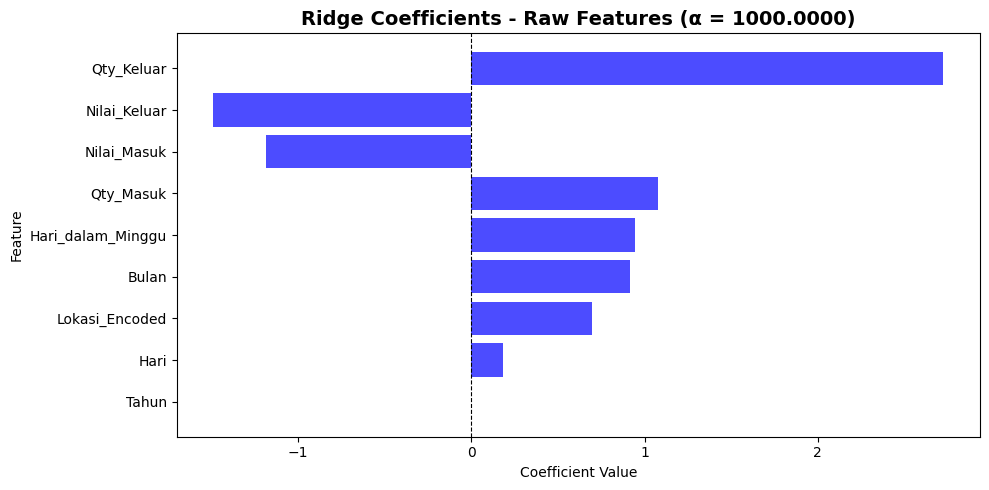

In [13]:
# ==============================================
# 11. RIDGE REGRESSION
# ==============================================
print("\n" + "="*70)
print("11. RIDGE REGRESSION (L2) - RAW FEATURES")
print("="*70)

ridge_cv = RidgeCV(cv=5, alphas=np.logspace(-3, 3, 100))
ridge_cv.fit(X_scaled, y)

print(f"\n📊 Alpha optimal (RidgeCV): {ridge_cv.alpha_:.4f}\n")

ridge = Ridge(alpha=ridge_cv.alpha_, random_state=42)
ridge.fit(X_scaled, y)

ridge_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_,
    'Abs_Coefficient': np.abs(ridge.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("Koefisien Ridge:")
print(ridge_coef.to_string(index=False))

# Visualisasi
plt.figure(figsize=(10, 5))
plt.barh(ridge_coef['Feature'], ridge_coef['Coefficient'], color='blue', alpha=0.7)
plt.gca().invert_yaxis()
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'Ridge Coefficients - Raw Features (α = {ridge_cv.alpha_:.4f})', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('ridge_raw_features.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# ==============================================
# 12. SUMMARY & COMPARISON
# ==============================================
print("\n" + "="*70)
print("12. SUMMARY - PERBANDINGAN SEMUA METODE (RAW FEATURES)")
print("="*70)

summary_data = []

# 1. Correlation
top_corr = stok_corr.drop('Stok_Aktual').head(5).index.tolist()
summary_data.append(['Correlation (Pearson)', ', '.join(top_corr)])

# 2. Random Forest
top_rf = rf_importance.head(5)['Feature'].tolist()
summary_data.append(['Random Forest Importance', ', '.join(top_rf)])

# 3. Mutual Information
top_mi = mi_df.head(5)['Feature'].tolist()
summary_data.append(['Mutual Information', ', '.join(top_mi)])

# 4. RFE
top_rfe = X.columns[rfe_final.support_].tolist()
summary_data.append(['RFE (Wrapper)', ', '.join(top_rfe)])

# 5. Lasso
lasso_display = ', '.join(selected_lasso) if len(selected_lasso) > 0 else 'No features selected'
summary_data.append(['Lasso (L1 Embedded)', lasso_display])

# 6. Ridge
top_ridge = ridge_coef.head(5)['Feature'].tolist()
summary_data.append(['Ridge (L2 Embedded)', ', '.join(top_ridge)])

summary_df = pd.DataFrame(summary_data, columns=['Metode', 'Fitur Terpilih (Top 5)'])
print("\n")
print(summary_df.to_string(index=False))


12. SUMMARY - PERBANDINGAN SEMUA METODE (RAW FEATURES)


                  Metode                                              Fitur Terpilih (Top 5)
   Correlation (Pearson)     Qty_Keluar, Hari_dalam_Minggu, Qty_Masuk, Bulan, Lokasi_Encoded
Random Forest Importance   Nilai_Keluar, Lokasi_Encoded, Qty_Keluar, Hari, Hari_dalam_Minggu
      Mutual Information         Nilai_Keluar, Qty_Masuk, Lokasi_Encoded, Nilai_Masuk, Tahun
           RFE (Wrapper)     Qty_Masuk, Qty_Keluar, Bulan, Hari_dalam_Minggu, Lokasi_Encoded
     Lasso (L1 Embedded)                                                          Qty_Keluar
     Ridge (L2 Embedded) Qty_Keluar, Nilai_Keluar, Nilai_Masuk, Qty_Masuk, Hari_dalam_Minggu



13. CONSENSUS ANALYSIS - RAW FEATURES

📊 Fitur Konsensus (Raw Features):
          Feature  Frequency
       Qty_Keluar          5
Hari_dalam_Minggu          4
        Qty_Masuk          4
   Lokasi_Encoded          4
     Nilai_Keluar          3
            Bulan          2
      Nilai_Masuk          2
             Hari          1
            Tahun          1


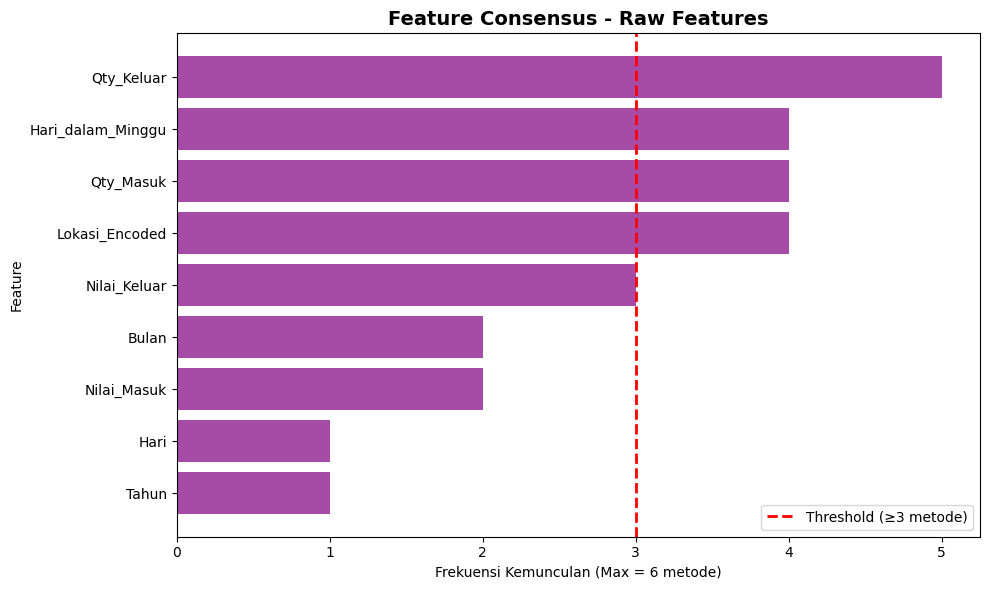

In [15]:
# ==============================================
# 13. CONSENSUS ANALYSIS
# ==============================================
print("\n" + "="*70)
print("13. CONSENSUS ANALYSIS - RAW FEATURES")
print("="*70)

from collections import Counter

all_top_features = (
    top_corr[:5] + 
    top_rf[:5] + 
    top_mi[:5] + 
    top_rfe[:5] + 
    (selected_lasso[:5] if len(selected_lasso) > 0 else []) +
    top_ridge[:5]
)

feature_counts = Counter(all_top_features)
consensus_features = pd.DataFrame(
    feature_counts.most_common(),
    columns=['Feature', 'Frequency']
)

print("\n📊 Fitur Konsensus (Raw Features):")
print(consensus_features.to_string(index=False))

# Visualisasi
plt.figure(figsize=(10, 6))
plt.barh(consensus_features['Feature'], consensus_features['Frequency'], color='purple', alpha=0.7)
plt.gca().invert_yaxis()
plt.axvline(x=3, color='red', linestyle='--', linewidth=2, label='Threshold (≥3 metode)')
plt.title('Feature Consensus - Raw Features', fontsize=14, fontweight='bold')
plt.xlabel('Frekuensi Kemunculan (Max = 6 metode)')
plt.ylabel('Feature')
plt.legend()
plt.tight_layout()
plt.savefig('consensus_raw_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# ==============================================
# 14. MODEL PERFORMANCE EVALUATION
# ==============================================
print("\n" + "="*70)
print("14. EVALUASI PERFORMA MODEL (RAW vs ENGINEERED)")
print("="*70)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model dengan semua fitur raw
rf_all = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_all.fit(X_train, y_train)
y_pred_all = rf_all.predict(X_test)

r2_all = r2_score(y_test, y_pred_all)
mae_all = mean_absolute_error(y_test, y_pred_all)

# Model dengan fitur consensus (frekuensi ≥3)
high_consensus = consensus_features[consensus_features['Frequency'] >= 3]['Feature'].tolist()
if len(high_consensus) > 0:
    X_train_consensus = X_train[high_consensus]
    X_test_consensus = X_test[high_consensus]
    
    rf_consensus = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf_consensus.fit(X_train_consensus, y_train)
    y_pred_consensus = rf_consensus.predict(X_test_consensus)
    
    r2_consensus = r2_score(y_test, y_pred_consensus)
    mae_consensus = mean_absolute_error(y_test, y_pred_consensus)
else:
    r2_consensus = 0
    mae_consensus = 0

print(f"""
📊 HASIL EVALUASI MODEL:

1. Model dengan SEMUA fitur raw ({len(X.columns)} fitur):
   - R² Score: {r2_all:.4f}
   - MAE: {mae_all:.2f}

2. Model dengan fitur CONSENSUS (≥3 metode, {len(high_consensus)} fitur):
   - R² Score: {r2_consensus:.4f}
   - MAE: {mae_consensus:.2f}

⚠️ INTERPRETASI:
   - R² Score yang RENDAH menunjukkan fitur raw TIDAK cukup prediktif
   - Fitur mentah (single transaction) tidak menangkap POLA produk
   - Ini membuktikan pentingnya FEATURE ENGINEERING!
""")


14. EVALUASI PERFORMA MODEL (RAW vs ENGINEERED)

📊 HASIL EVALUASI MODEL:

1. Model dengan SEMUA fitur raw (9 fitur):
   - R² Score: -3.2921
   - MAE: 17.59

2. Model dengan fitur CONSENSUS (≥3 metode, 5 fitur):
   - R² Score: -1.1377
   - MAE: 13.01

⚠️ INTERPRETASI:
   - R² Score yang RENDAH menunjukkan fitur raw TIDAK cukup prediktif
   - Fitur mentah (single transaction) tidak menangkap POLA produk
   - Ini membuktikan pentingnya FEATURE ENGINEERING!



In [19]:
# ==============================================
# 15. KESIMPULAN AKHIR
# ==============================================
print("\n" + "="*70)
print("15. KESIMPULAN - RAW FEATURES")
print("="*70)

high_consensus_features = consensus_features[consensus_features['Frequency'] >= 3]['Feature'].tolist()

print(f"""
RINGKASAN ANALISIS RAW FEATURES:

1. FITUR YANG DIGUNAKAN:
   - Total fitur raw: {len(X.columns)}
   - Fitur: {', '.join(X.columns.tolist())}
   
2. FITUR KONSENSUS TINGGI (≥3 metode):
""")

for i, feat in enumerate(high_consensus_features, 1):
    freq = consensus_features[consensus_features['Feature'] == feat]['Frequency'].values[0]
    print(f"   {i}. {feat} (muncul di {freq}/6 metode)")

print(f"""
3. PERFORMA MODEL:
   - R² Score (all features): {r2_all:.4f}
   - R² Score (consensus): {r2_consensus:.4f}
""")
print("="*70)


15. KESIMPULAN - RAW FEATURES

RINGKASAN ANALISIS RAW FEATURES:

1. FITUR YANG DIGUNAKAN:
   - Total fitur raw: 9
   - Fitur: Qty_Masuk, Nilai_Masuk, Qty_Keluar, Nilai_Keluar, Bulan, Tahun, Hari, Hari_dalam_Minggu, Lokasi_Encoded

2. FITUR KONSENSUS TINGGI (≥3 metode):

   1. Qty_Keluar (muncul di 5/6 metode)
   2. Hari_dalam_Minggu (muncul di 4/6 metode)
   3. Qty_Masuk (muncul di 4/6 metode)
   4. Lokasi_Encoded (muncul di 4/6 metode)
   5. Nilai_Keluar (muncul di 3/6 metode)

3. PERFORMA MODEL:
   - R² Score (all features): -3.2921
   - R² Score (consensus): -1.1377



## Referensi

[1] L. Breiman, "Random forests," Machine Learning, vol. 45, no. 1, pp. 5–32, 2001. https://doi.org/10.1023/A:1010933404324

[2] G. Chandrashekar and F. Sahin, "A survey on feature selection methods," Computers & Electrical Engineering, vol. 40, no. 1, pp. 16–28, 2014. https://doi.org/10.1016/j.compeleceng.2013.11.024

[3] T. M. Cover and J. A. Thomas, "Elements of Information Theory," 2nd ed., Wiley-Interscience, 2006. https://doi.org/10.1002/0471200611

[4] J. L. Rodgers and W. A. Nicewander, "Thirteen ways to look at the correlation coefficient," The American Statistician, vol. 42, no. 1, pp. 59–66, 1988. https://doi.org/10.2307/2685263

[5] I. Guyon, J. Weston, S. Barnhill, and V. Vapnik, "Gene selection for cancer classification using support vector machines," Machine Learning, vol. 46, no. 1-3, pp. 389–422, 2002. https://doi.org/10.1023/A:1012487302797

[6] R. Tibshirani, "Regression shrinkage and selection via the lasso," Journal of the Royal Statistical Society: Series B (Methodological), vol. 58, no. 1, pp. 267–288, 1996. https://doi.org/10.1111/j.2517-6161.1996.tb02080.x

[7] A. E. Hoerl and R. W. Kennard, "Ridge regression: Biased estimation for nonorthogonal problems," Technometrics, vol. 12, no. 1, pp. 55–67, 1970. https://doi.org/10.1080/00401706.1970.10488634

---